<a href="https://colab.research.google.com/github/AndreaCorrado00/Emotion-recognition-throught-Deep-Learning-/blob/main/emotions_eeg_lstm_gru_dnn_98_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ORIGINALE](https://www.kaggle.com/code/tenebris97/emotions-eeg-lstm-gru-dnn-98-44/notebook)

[lezione deep learning del prof](https://colab.research.google.com/drive/1wwXvCMkt-kRMCbizb5RgaR14HWNkmccP#scrollTo=XxNS0hVTzeGP)

[articolo da leggere per capire il database](https://www.researchgate.net/publication/335173767_A_Deep_Evolutionary_Approach_to_Bioinspired_Classifier_Optimisation_for_Brain-Machine_Interaction)

[Notebook che usano lo stesso dataset](https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions/code)

Cose da analizzare per migliorare il progetto


1.   come il dataset viene letto dalla rete ricorsiva
2.   divisione del dataset: soggetti a e b come train e test?
3.   struttura del codice più orientata agli oggetti, migliorare le dichiarazioni dei modelli, delle funzioni plot...
4. valutazione dell'importanza delle features

**Prossimi steps**
1. struttura orientata agli oggetti: ok
2. valutazione importanza delle features e tuning hyperparam (?)
3. trovare dei candidati del modello da testare sulla pipline 2

**Brainstorming chat gpt**

Abbiamo discusso due possibili pipeline di lavoro per affrontare il problema di modellare l'evoluzione temporale delle variabili per i soggetti "a" e "b" e distinguere le eventuali differenze tra di essi:

Pipeline 1:

Costruire il train set sui soggetti "a" e poi testare sui soggetti "b", con una porzione del train test come validation set.
Pro: Segue un approccio standard e permette di valutare la capacità del modello di generalizzare su dati non visti.
Contro: Potrebbe causare sovradattamento sul train set e non catturare pienamente le differenze intrinseche tra i due soggetti.
Pipeline 2:

Dividere il dataset originale in subset "a" e "b" e eseguire split indipendenti per train, validation e test set su ciascun subset.
Eseguire il training della stessa architettura di modello per i due gruppi e confrontare statisticamente i parametri del modello tra i due gruppi.
Pro: Permette di valutare direttamente le differenze tra i due gruppi e identificare variazioni significative.
Contro: Potrebbe essere più suscettibile a problemi di sovrapposizione o confondimento tra i gruppi durante la suddivisione dei dati.
Abbiamo anche discusso delle criticità nell'approccio di addestrare prima il modello sulla Pipeline 1 e poi passare alla Pipeline 2, tra cui il rischio di sovradattamento del modello complesso sui dati del dataset completo e la difficoltà dei modelli addestrati sui subset "a" e "b" a generalizzare efficacemente.

Per mitigare queste criticità, sono state suggerite alcune strategie come la riduzione della complessità del modello, l'uso della regolarizzazione, la cross-validation e la selezione delle caratteristiche.




# **1- Packages**

In [1]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# libraries to interface with the os
from os.path import join
from glob import glob



warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
  print('no Gpu')

Found 1 GPU


# **2- Data Preparation & EDA**

##**2.1 - EDA and feature analysis**

In [3]:
# Mounthing google drive to access data.
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive"
# Be sure to have a shortcutof the .zip folder in your drive main page.


Mounted at /content/drive
/content/drive/MyDrive


 the dataset is made like that: on the rows expriments, on the columns features. Variables are for both subject collected in the same line, thus insead of heaving two different acquisition (and in conclusion datasets)  we have a single "continuous" acquistion. so the time "flown" trought the rows.

 A possibile check to do is try to divide the dataset in two elements and perform crossed checks, for example by usign subject a to train and subject b to test after checking that it is possible to do it.

 NB: in teoria ogni variabile (colonna) è il valore della variabile su un instante temporale di un secondo, campionato poi a 200Hz


In [4]:
df = pd.read_csv('emotions.csv')
df.head()
print(df.shape)



(2132, 2549)


----------- NaN check ----------------
No missing values

----------- Balance check ----------------
Classes are balanced
label
NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='label'>

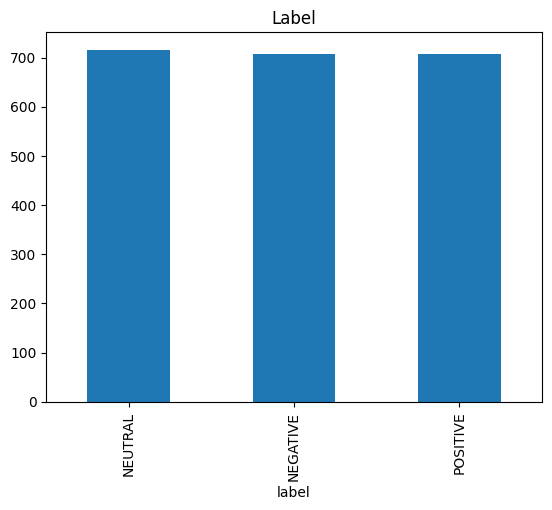

In [5]:
# Checking for missing values
print('----------- NaN check ----------------')
if df.isna().sum().sum()==0:
  print('No missing values')
else:
  print('Missing values in columns:')
  for col in df.columns:
    if(df[col].isnull().sum()>0):
          print(col)
print()
print('----------- Balance check ----------------')


def are_almost_equal(numbers, threshold):
    # Check if absolute differences between all pairs of numbers are within the threshold
    for i in range(len(numbers)):
        for j in range(i+1, len(numbers)):
            if abs(numbers[i] - numbers[j]) > threshold:
                return False
    return True

result=are_almost_equal(df.label.value_counts(),(np.max(df.label.value_counts())-np.min(df.label.value_counts()))+10)

if result:
  print('Classes are balanced')
else:
  print('Classe are unbalanced')

print(df.label.value_counts())
df.label.value_counts().plot(kind='bar', color='tab:blue', title='Label')

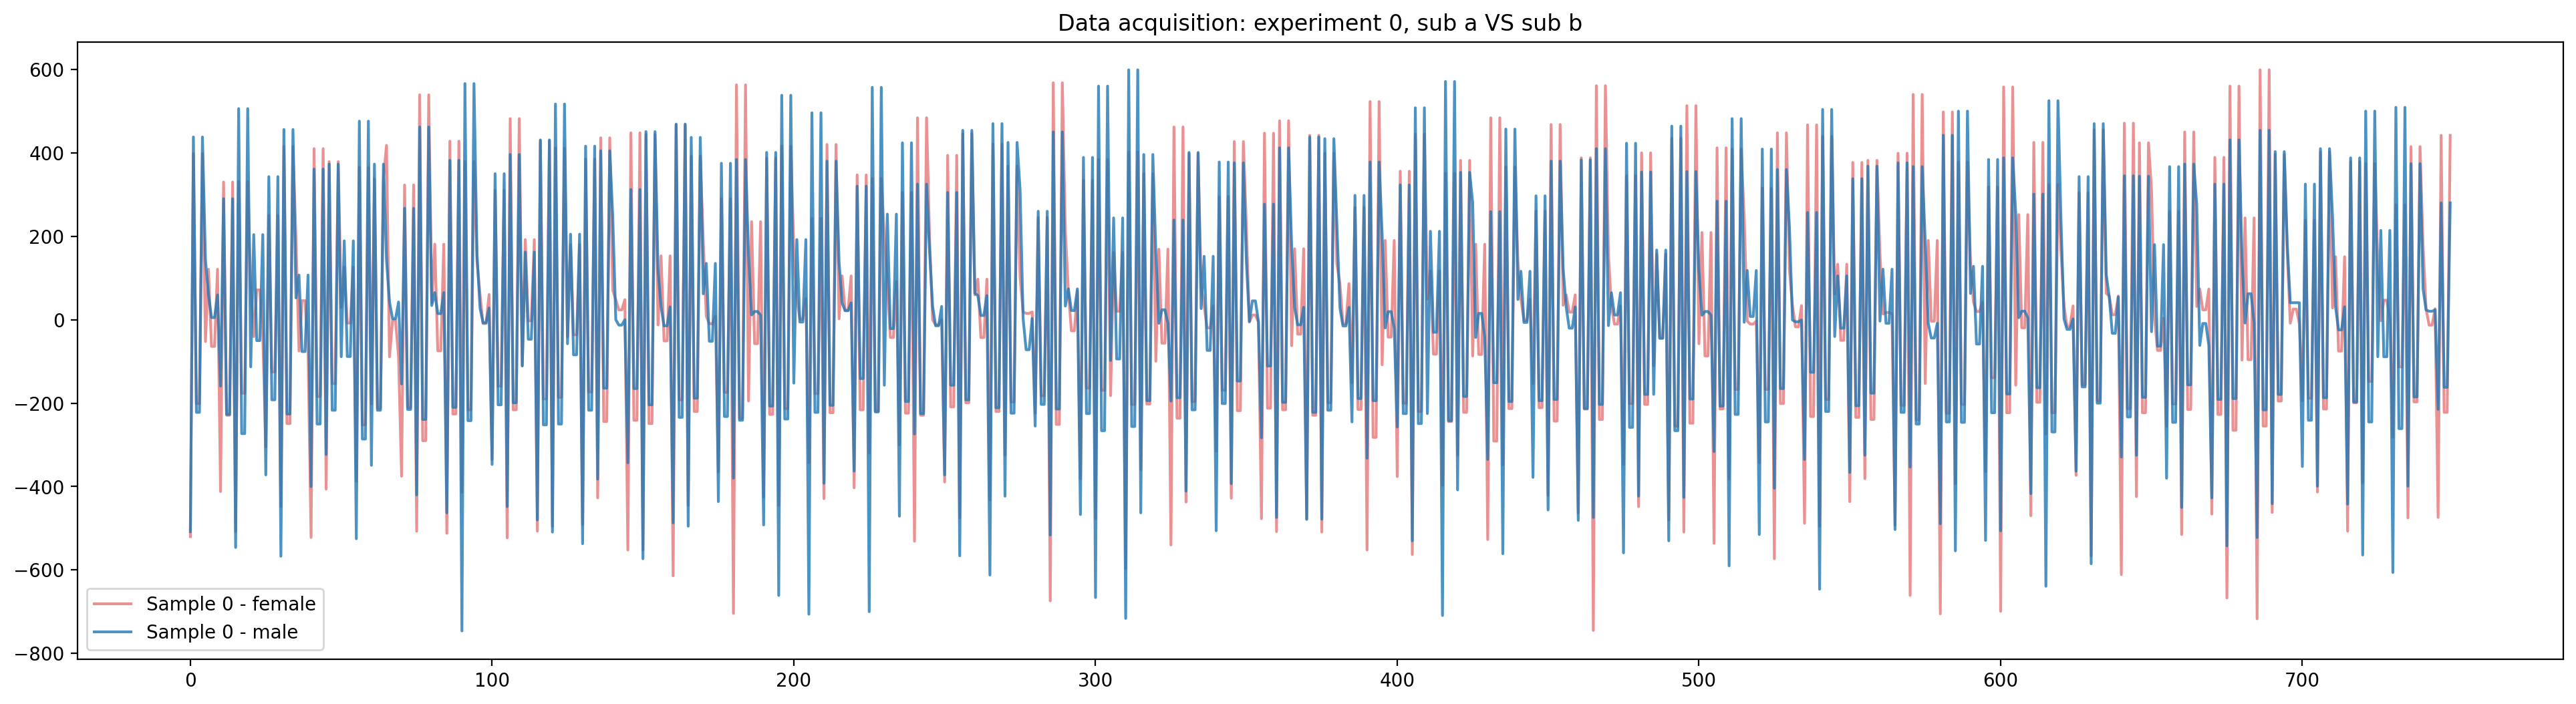

In [6]:
plt.figure(dpi=200, figsize=(24, 6))

index_values = range(len(df.loc[0, 'fft_0_a':'fft_749_a']))
plt.plot(index_values,df.loc[0, 'fft_0_a':'fft_749_a'], label='Sample 0 - female', color='tab:red', alpha=.5)
plt.plot(index_values,df.loc[0, 'fft_0_b':'fft_749_b'], label='Sample 0 - male ', color='tab:blue', alpha=.8)

plt.legend(loc='best')
plt.title('Data acquisition: experiment 0, sub a VS sub b')
plt.show()

# Assumption: subject a is the female, subject b is the male. Just to have an idea.

Text(0.5, 0.98, 'Examples of acquisitions trought experiments')

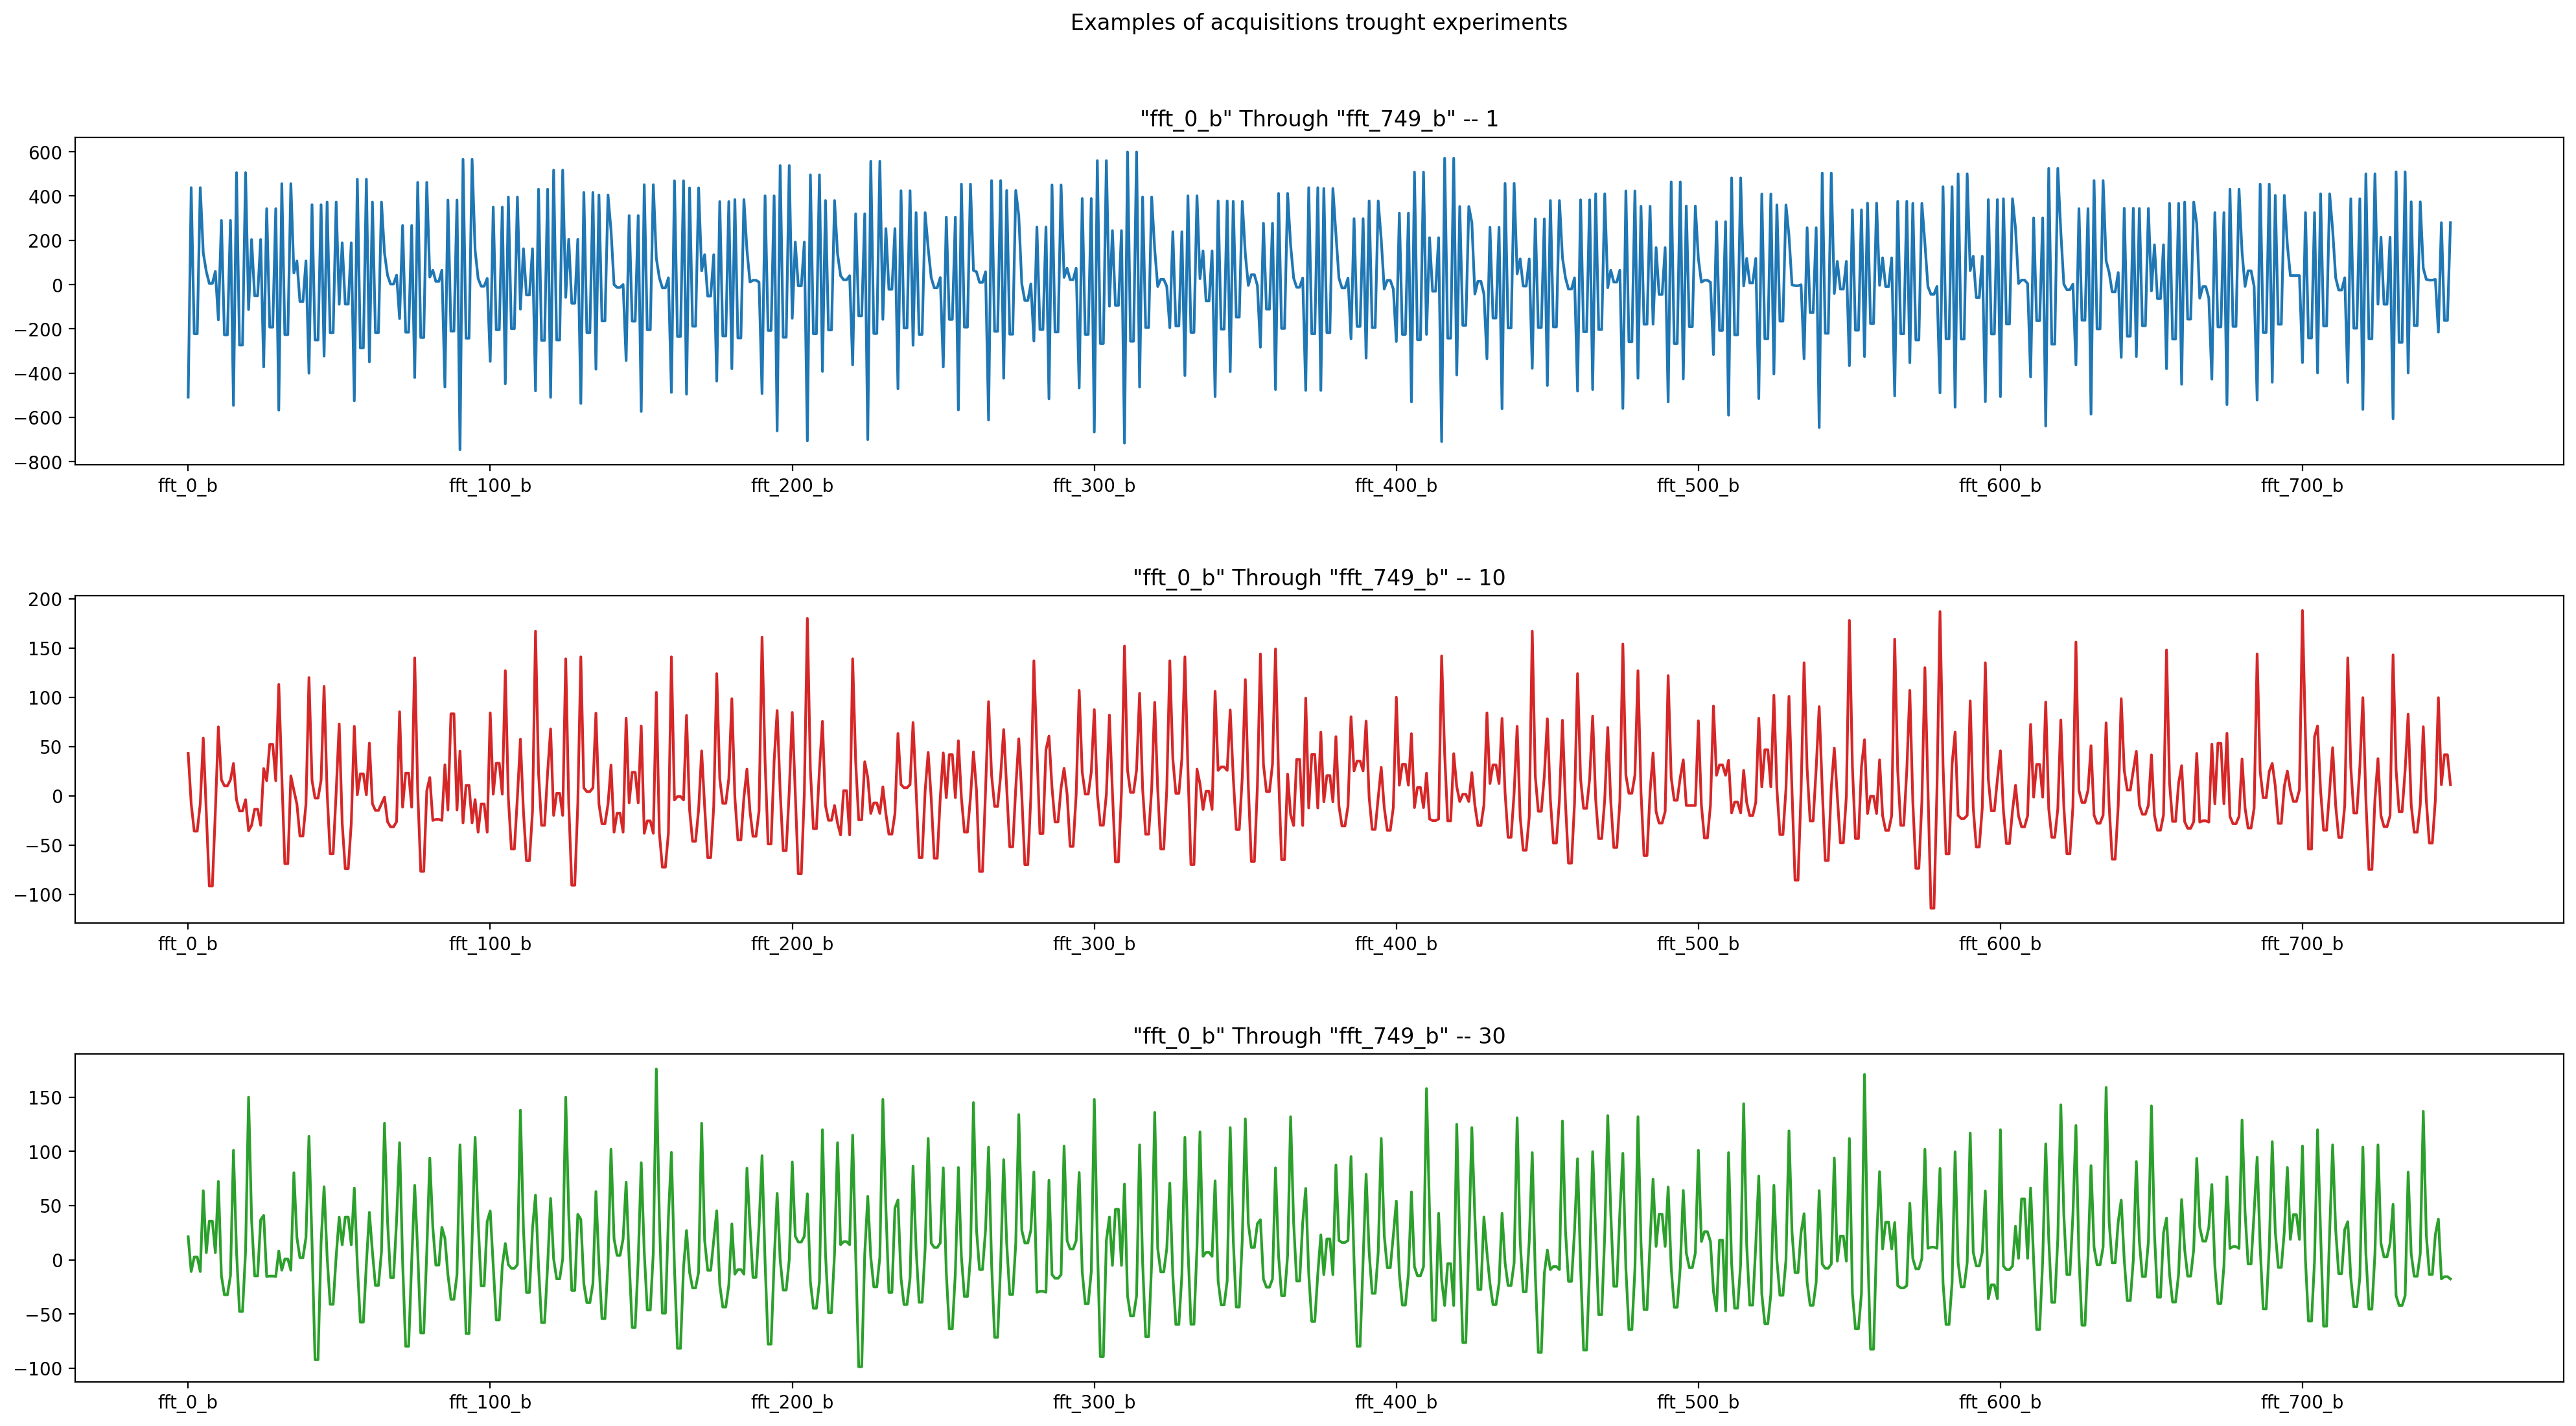

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))

df.loc[0, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 1', color='tab:blue', ax=axes[0])
df.loc[10, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 10', color='tab:red', ax=axes[1])
df.loc[30, 'fft_0_b':'fft_749_b'].plot(title='\"fft_0_b\" Through \"fft_749_b\" -- 30', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1,
                    right=0.9, top=0.9,
                    wspace=0.4, hspace=0.4)
fig.suptitle('Examples of acquisitions trought experiments')


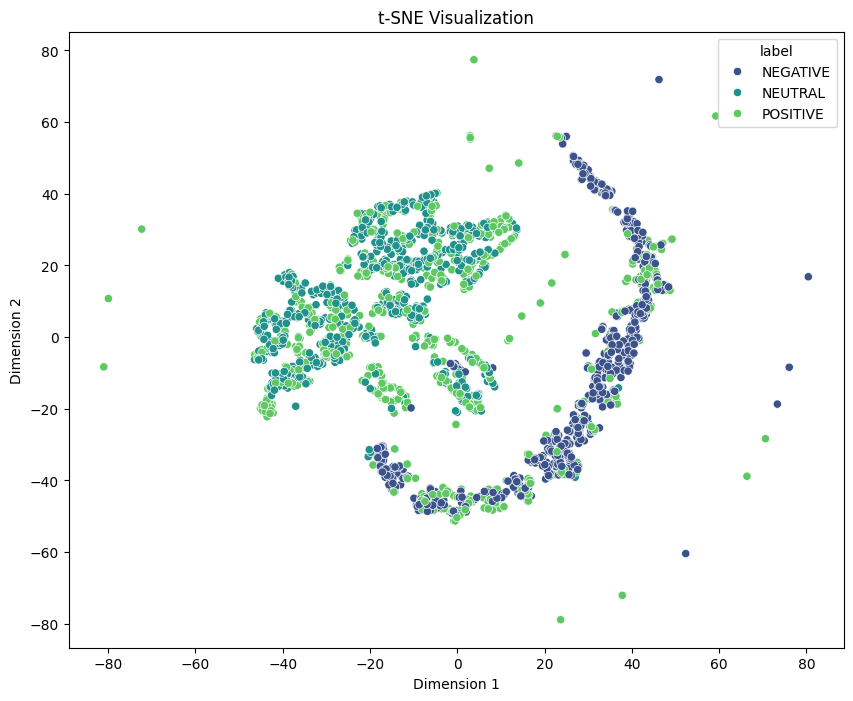

In [8]:
# t-SNE Visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df.drop('label', axis=1))
tsne_df = pd.DataFrame(tsne_results, columns=['Dimension 1', 'Dimension 2'])
tsne_df['label'] = df['label']
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='label', data=tsne_df, palette='viridis')
plt.title("t-SNE Visualization")
plt.show()

## **2.1 - Data preparation**

In [9]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,1
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,2
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,1


In [14]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris

print(X.shape)
# Calcola la mutual information
mi_scores = mutual_info_classif(X, Y)

# Crea un DataFrame per visualizzare i risultati
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

# Seleziona le feature più informative (ad esempio le prime 5)
num_features_to_select = 100
selected_features = mi_df['Feature'][:num_features_to_select]

print("Feature più informative:")
print(selected_features)




(2132, 2548)
Feature più informative:
210       covmat_0_a
1484      covmat_0_b
2           mean_2_a
1276        mean_2_b
1286     mean_d_2_b2
            ...     
1434       min_q_0_b
82      moments_12_a
1640        logm_0_b
366         logm_0_a
1299     mean_d_15_b
Name: Feature, Length: 100, dtype: object


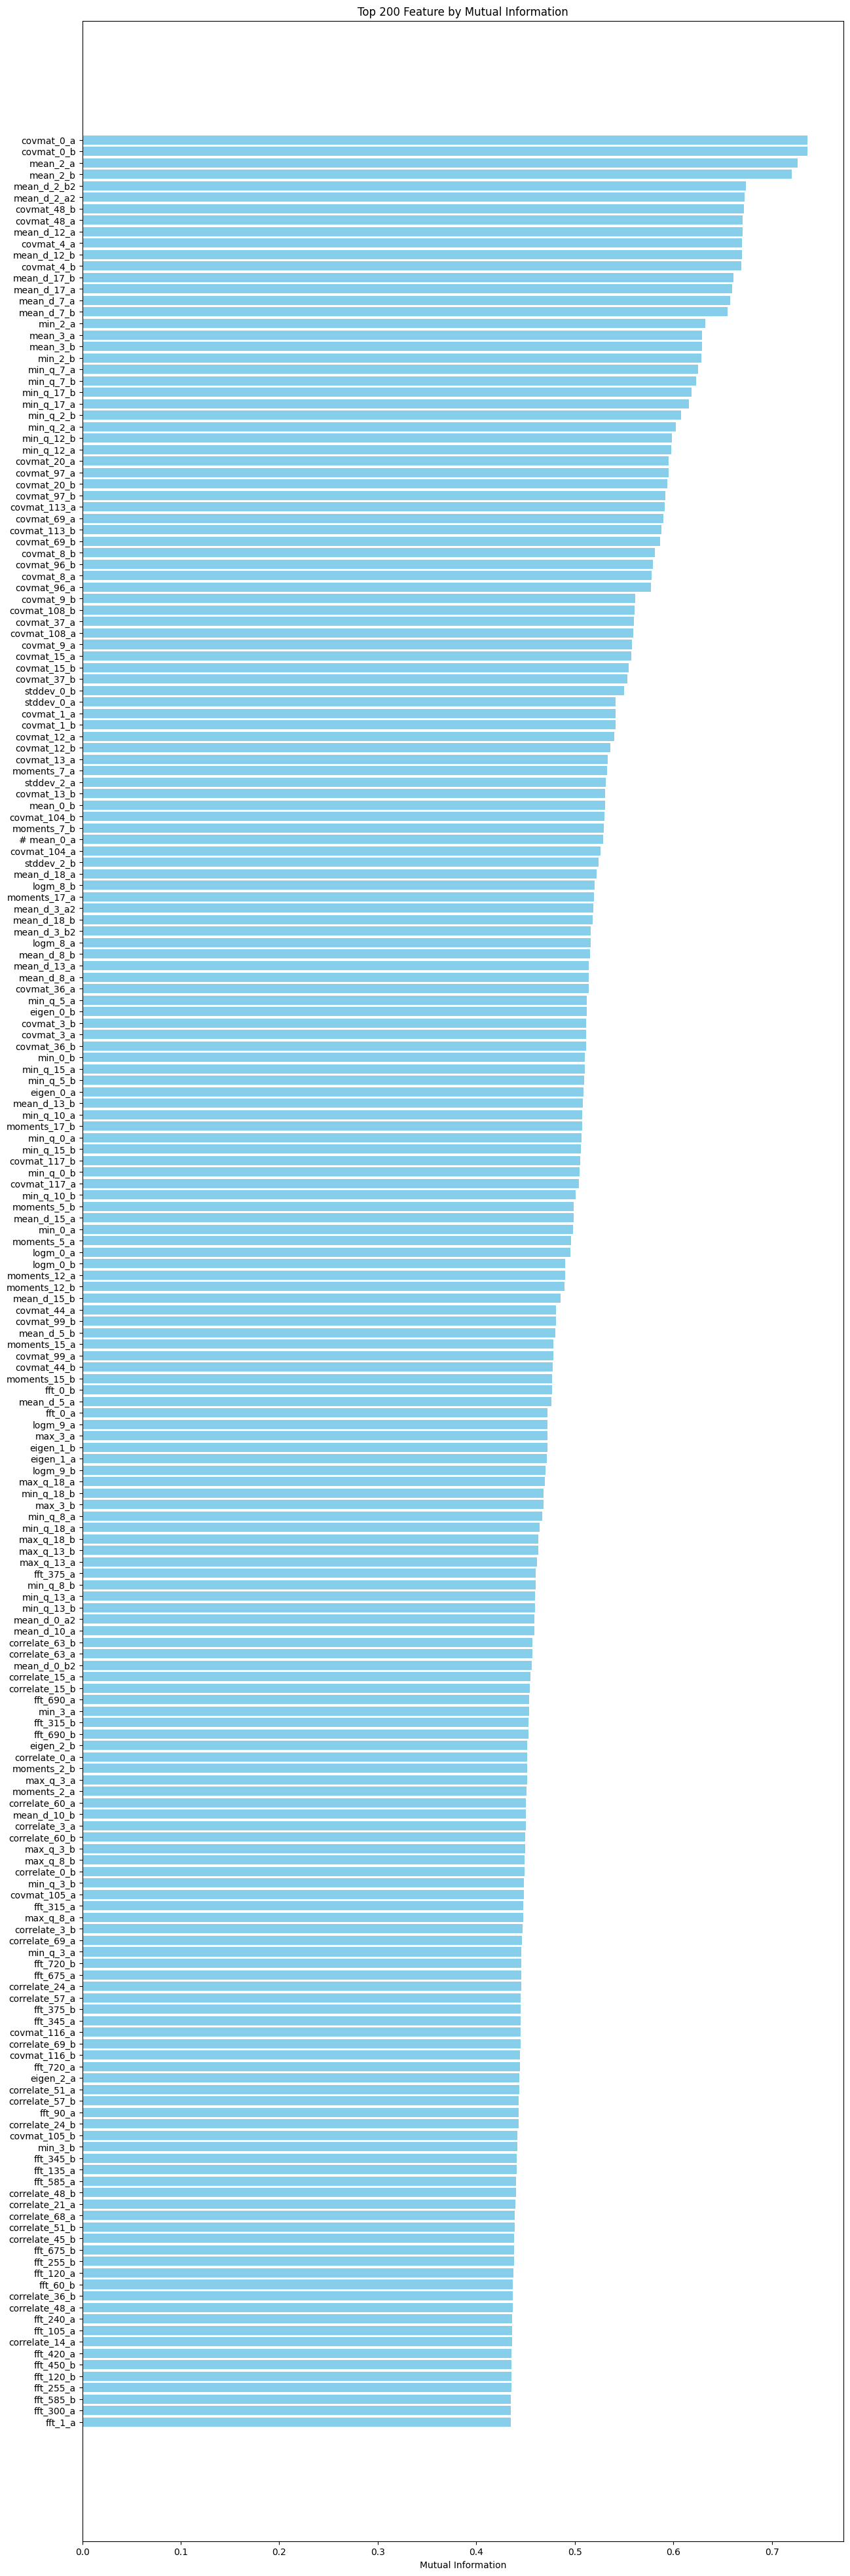

In [12]:
# Seleziona le 500 feature più informative
num_features_to_select = 200
top_features = mi_df.iloc[:num_features_to_select]

# Plot dei valori di mutual information per le top 500 feature
plt.figure(figsize=(15,50))
plt.barh(top_features['Feature'], top_features['Mutual_Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.title(f'Top {num_features_to_select} Feature by Mutual Information')
plt.gca().invert_yaxis()
plt.show()

## IDEA: tenere solo quelle che hanno sopra lo 0.45 di MI?

*Some comments about EDA*

There are two main aspects about the dataset that surprise me:
1. data are not really collected as time series, instead there are 2 sub-blocks:
    
    a. one related to the varibles collectect in different time frames (means, covariances..., first columns of the dataset)
    
    b. a second one related to the real FFT of the signal

  Only data b) can be actually intepreted as a time series to be used into a RNN as they are. Moreover, looking at MI exploration there aren't variables stronghly more informative than others. In particular, even if some of them seems to carry out an higher MI, the same variables collected from a different time step doesn't appear as informative as the other, suggesting a bit of "confusion".

2. Technically, this scenario can be tretaed in 3 possibile ways:

    a. By considering the daataset as it is: each variable is a sort of descriptor without a real time significance (i.e. my signal has a certain mean in frame 1, a certain value of fft at frequency 0, 100...)

    b. By dividing the dataset into 2 parts, one related to variables (treathed as above), one related to the real time-dependent signal (fft)

    c. By adding a dimension into the dataset, the time, and by rebuilding the dataset in a way such that in position i.e. (1,1) there are all the variables values related to the first time frame.

  Now possibility a) and b) are followed and explored. So 3 dataset will be explored: one with all variables, one with only fft, one with only variables without time.

  Two models frames will be used: one DNN on the whole datset and on the "only variables" subset, RNN on fft data.


In [16]:


all_dataset=True
only_fft=False

# case 1
if all_dataset==True and only_fft==False:
    # normalization
  columns_df=X.columns
  X= StandardScaler().fit_transform(X)
  X=pd.DataFrame(X,columns=columns_df)

  print('Whole dataset will be used, option a) choosen \n')
  X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.2)
  X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

# case 2
elif all_dataset==False and only_fft==True:
  print('Only fft time series columns are used \n')
  fft_columns=X.columns[X.columns.str.contains('fft')]
  X_fft=X[fft_columns]

  X_train, x_test, Y_train, y_test = train_test_split(X_fft, Y,random_state=111, test_size=0.2)
  X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

# case 3
elif all_dataset==False and only_fft==False:
  print('Only time indipendent columns are used \n')
  variables_columns=X.columns[~X.columns.str.contains('fft')]
  X_variables=X[variables_columns]
  #print(X_variables)

  # normalization
  X_variables = StandardScaler().fit_transform(X_variables)
  X_variables=pd.DataFrame(X_variables,columns=X[variables_columns].columns)

  X_train, x_test, Y_train, y_test = train_test_split(X_variables, Y,random_state=111, test_size=0.2)
  X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.2)

# showing the dataframe
X_train.head()
x_test.head()



Whole dataset will be used, option a) choosen 



,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
1835,0.186053,-0.551925,-0.412292,-0.290201,0.024642,0.171582,0.054744,-0.170405,0.012537,-0.285436,...,-1.493672,1.586264,-1.667884,-1.667884,1.586264,-0.420201,0.560653,-0.769657,-0.769657,0.560653
1537,1.076045,0.581621,0.674877,1.001386,0.052842,0.162125,-0.048580,0.094272,0.133671,0.050522,...,1.013339,-0.442135,0.670392,0.670392,-0.442135,0.821904,-0.301776,0.821531,0.821531,-0.301776
804,0.827371,0.430482,0.627356,0.817636,0.081043,-0.120449,-0.115700,0.074591,-0.226790,-0.170809,...,0.513279,-0.513717,0.324377,0.324377,-0.513717,0.700897,-0.279624,-0.239887,-0.239887,-0.279624
1019,-0.553425,0.365708,0.590503,-0.500625,0.045792,0.216082,-0.117816,-0.000524,-0.057320,-0.143869,...,0.533416,-0.366835,0.324377,0.324377,-0.366835,0.162770,-0.562670,0.307729,0.307729,-0.562670
1150,0.905900,0.506051,0.650632,0.811708,0.038742,-0.213342,-0.003524,0.069597,-0.300293,0.188392,...,0.644167,-0.489358,0.486415,0.486415,-0.489358,0.296945,-0.480414,1.335332,1.335332,-0.480414


In [30]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)

# **3- Modeling**

The goal here is finding the best model which involves the lowest number of features in the analysis. Here the aim is not finding performances roughly but finding the best structure of the model to proceed in a secon time with the analysis of the groups using the model archtepture found.

Here I define some functions to show the results in a second moment

In [18]:
def metrics_evolution(model, model_type='Deep Neural Network'):
  acc = model.history['accuracy']
  val_acc = model.history['val_accuracy']

  loss = model.history['loss']
  val_loss = model.history['val_loss']


  plt.figure(figsize=(12, 12))

  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy', color='r')
  plt.plot(val_acc, label='Validation Accuracy', color='b')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(loc='lower right', fontsize=13)
  plt.ylabel('Accuracy', fontsize=16, weight='bold')
  plt.title(f'{model_type} - Training & Validation Acc.', fontsize=16, weight='bold')


  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss', color='r')
  plt.plot(val_loss, label='Validation Loss', color='b')
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(loc='upper right', fontsize=13)
  plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
  plt.title(f'{model_type} - Training & Validation Loss', fontsize=15, weight='bold')
  plt.xlabel('Epoch', fontsize=15, weight='bold')

  plt.show()

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

In [20]:
def model_performances(model, x_test, y_test,normalized_CM=True, model_type='Deep Neural Network'):

  lstm_best = load_model(model)
  lstm_acc = lstm_best.evaluate(x_test, y_test, verbose=0)[1]
  print('------------------------------------------------------------------')
  print(f'Model performances of model {model_type} saved as {model}:\n')
  print("Test Acc.: {:.3f}%".format(lstm_acc * 100))
  print()
  y_pred = np.array(list(map(lambda x: np.argmax(x), lstm_best.predict(x_test))))
  cm = confusion_matrix(y_test.idxmax(axis=1), y_pred)
  print(classification_report(y_test.idxmax(axis=1), y_pred))

  cnf_matrix = confusion_matrix(y_test.idxmax(axis=1), y_pred)
  np.set_printoptions(precision=2)

  plt.figure(figsize=(10, 10))
  if normalized_CM:
    title=f'{model_type} - Normalized Confusion Matrix'
  else:
    title=f'{model_type} - Confusion Matrix'

  plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=normalized_CM,
                        title=title)
  plt.show()

## **3.1 FFT subset**

Both LSTM and GRU framework are used to investigate the best solution to model fft data

### **Model 1: LSTM on fft subset**

In [ ]:
def rnn_model(x_train,n_classes,n_recurrent_neurons,model_type='lstm'):
  input_layer = keras.layers.Input(shape=(x_train.shape[1], 1))

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(input_layer)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(input_layer)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Flatten()(x)
  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

In [ ]:
lstm_model = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='lstm'
)
print(lstm_model.summary())
keras.utils.plot_model(lstm_model, "lstm.png", show_shapes=True)

In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

lstm_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
if all_dataset==False and only_fft==True:
  print('fft signal modeling throught LSTM')
  lstm_h = lstm_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

In [ ]:
if all_dataset==False and only_fft==True:
  metrics_evolution(lstm_h, model_type='LSTM')
  model_performances(model='./best_lstm_model.h5',x_test=x_test,y_test=y_test,model_type='LSTM',normalized_CM=True)

### **Model 2: GRU on fft subset**

In [ ]:
gru_model = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='gru'
)
print(gru_model.summary())
keras.utils.plot_model(gru_model, "gru.png", show_shapes=True)

In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_gru_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

gru_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

if all_dataset==False and only_fft==True:
  print('fft signal modeling throught GRU')
  gru_h = gru_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[es, mc, lr_schedule])

In [ ]:
metrics_evolution(gru_h, model_type='GRU')
model_performances(model='./best_gru_model.h5',x_test=x_test,y_test=y_test,model_type='GRU',normalized_CM=True)

## **3.2 Variables subset**

Here DNN with a standard architeputure is used to model these data


In [45]:
def dnn_model(x_train,n_classes,dense_layers):
  input_layer=keras.layers.Input(shape=(x_train.shape[1], ))

  x = keras.layers.Masking(mask_value=-1)(input_layer)

  for n in dense_layers:
    x = keras.layers.Dense(n,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2548)]            0         
                                                                 
 masking_6 (Masking)         (None, 2548)              0         
                                                                 
 dense_34 (Dense)            (None, 128)               326272    
                                                                 
 batch_normalization_28 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 128)               16512     
                                                           

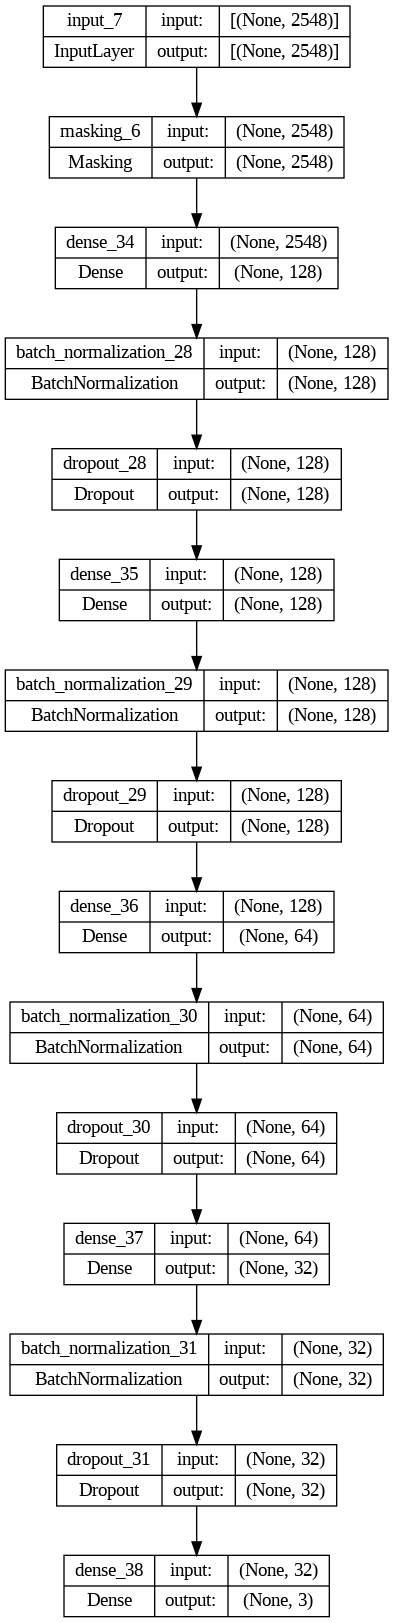

In [42]:
dnn_model = dnn_model(
    x_train=X_train,
    n_classes=3,
    dense_layers=[128,128,64,32]
)
print(dnn_model.summary())
keras.utils.plot_model(dnn_model, "dnn_1.png", show_shapes=True)

In [23]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_dnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

if all_dataset==False and only_fft==False:
  print('Variables modelling throught dnn')
  dnn_h = dnn_model.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

In [25]:
if all_dataset==False and only_fft==False:
  metrics_evolution(dnn_h, model_type='DNN')
  model_performances(model='./best_dnn_model.h5',x_test=x_test,y_test=y_test,model_type='DNN',normalized_CM=True)

##**3.3 Whole dataset**
Here I use a DNN to model all the dataset. In this case using a LSTM framework doesn't have much sense, it's better proceeding with a standard net.


In [46]:
def dnn_model(x_train,n_classes,dense_layers):
  input_layer=keras.layers.Input(shape=(x_train.shape[1], ))

  x = keras.layers.Masking(mask_value=-1)(input_layer)

  for n in dense_layers:
    x = keras.layers.Dense(n,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2548)]            0         
                                                                 
 masking_7 (Masking)         (None, 2548)              0         
                                                                 
 dense_39 (Dense)            (None, 256)               652544    
                                                                 
 batch_normalization_32 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_32 (Dropout)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 256)               65792     
                                                           

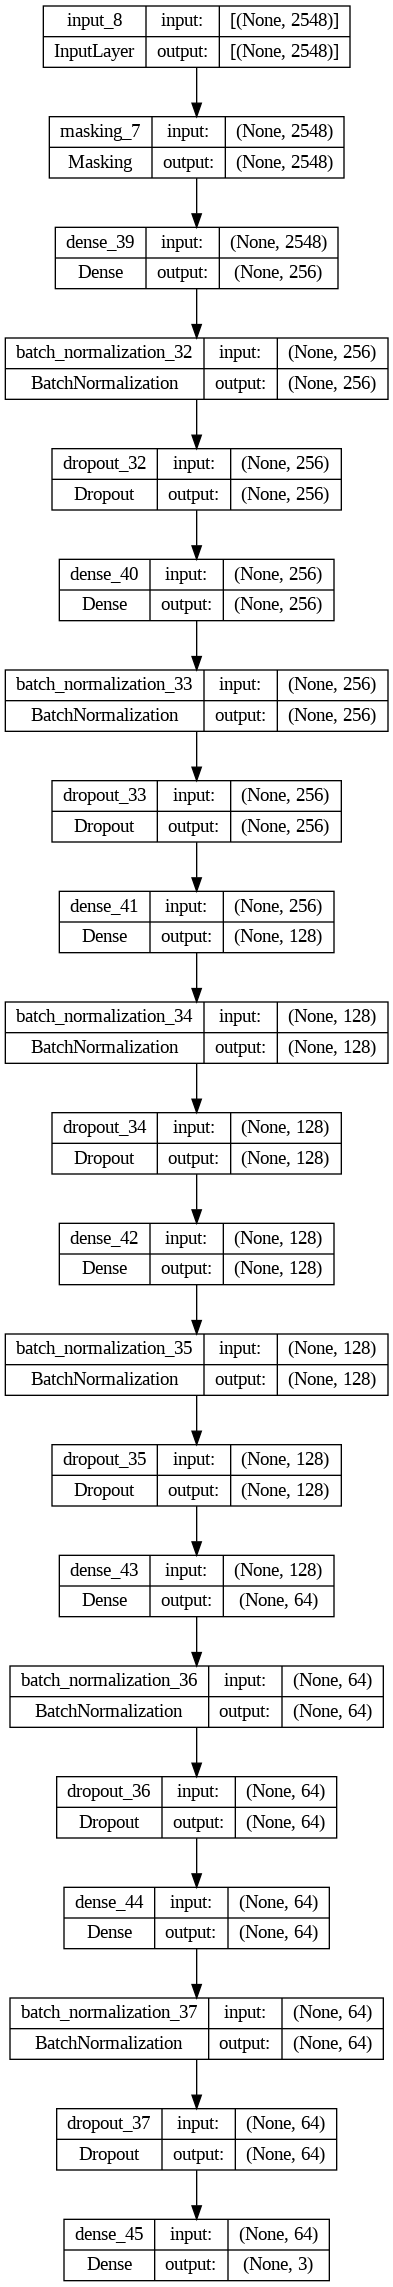

In [47]:
dnn_model_whole = dnn_model(
    x_train=X_train,
    n_classes=3,
    dense_layers=[256,256,128,128,64,64]
)
print(dnn_model_whole.summary())
keras.utils.plot_model(dnn_model_whole, "dnn_2.png", show_shapes=True)

In [48]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_dnn_whole_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model_whole.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

if all_dataset==True and only_fft==False:
  print('Variables modelling throught dnn')
  dnn_whole_h = dnn_model_whole.fit(X_train, Y_train,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ es,mc, lr_schedule])

Variables modelling throught dnn
Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.6899
Epoch 1: val_accuracy improved from -inf to 0.75660, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 13s 58ms/step - loss: 0.8303 - accuracy: 0.6899 - val_loss: 0.5839 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.8460
Epoch 2: val_accuracy improved from 0.75660 to 0.89150, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 1s 22ms/step - loss: 0.4466 - accuracy: 0.8460 - val_loss: 0.3045 - val_accuracy: 0.8915 - lr: 9.0484e-04
Epoch 3/50
40/43 [==========================>...] - ETA: 0s - loss: 0.3447 - accuracy: 0.8727
Epoch 3: val_accuracy improved from 0.89150 to 0.92082, saving model to ./best_dnn_whole_model.h5
43/43 [==============================] - 1s 24ms/step - loss: 0.3528 - accuracy: 0.8710 - val_loss: 0.2

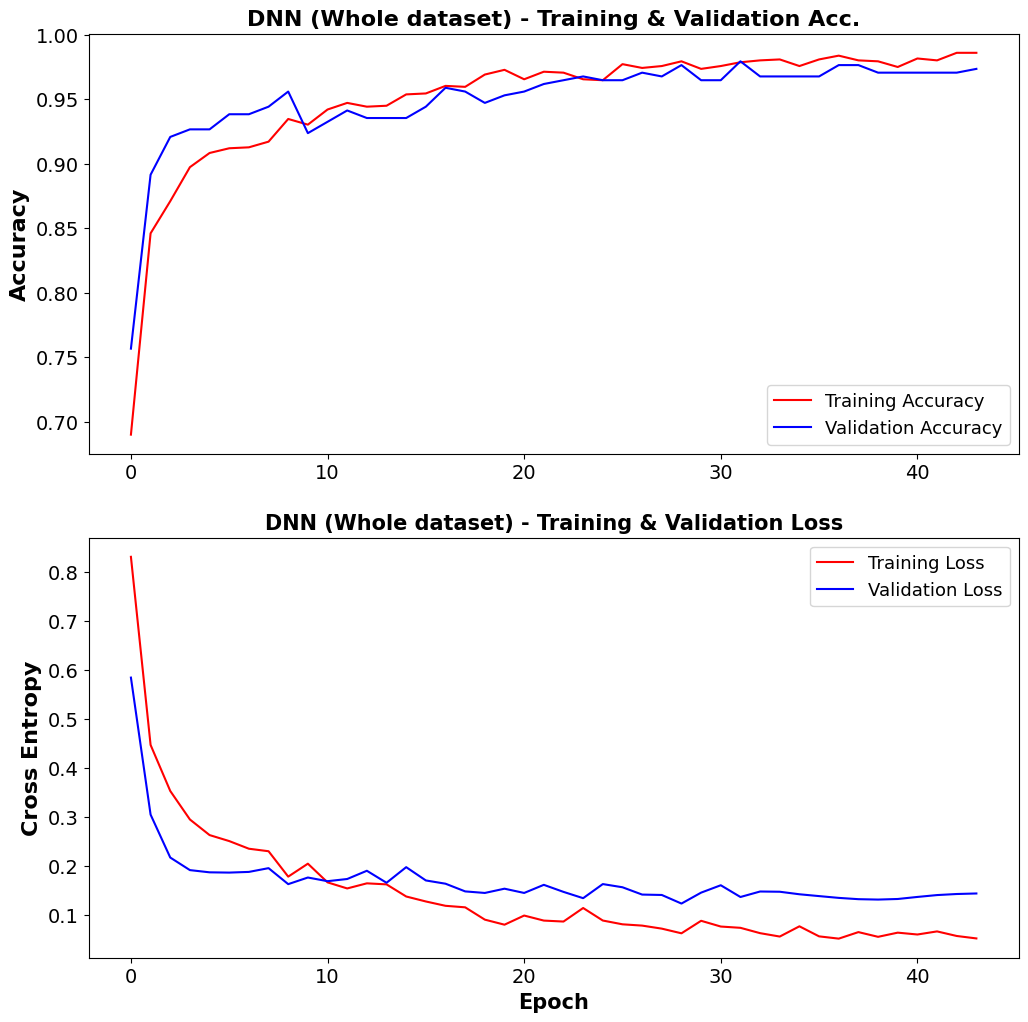

------------------------------------------------------------------
Model performances of model DNN (Whole dataset) saved as ./best_dnn_whole_model.h5:

Test Acc.: 97.424%

14/14 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       115
           1       0.98      0.99      0.98       164
           2       0.98      0.95      0.96       148

    accuracy                           0.97       427
   macro avg       0.97      0.98      0.97       427
weighted avg       0.97      0.97      0.97       427

Normalized confusion matrix


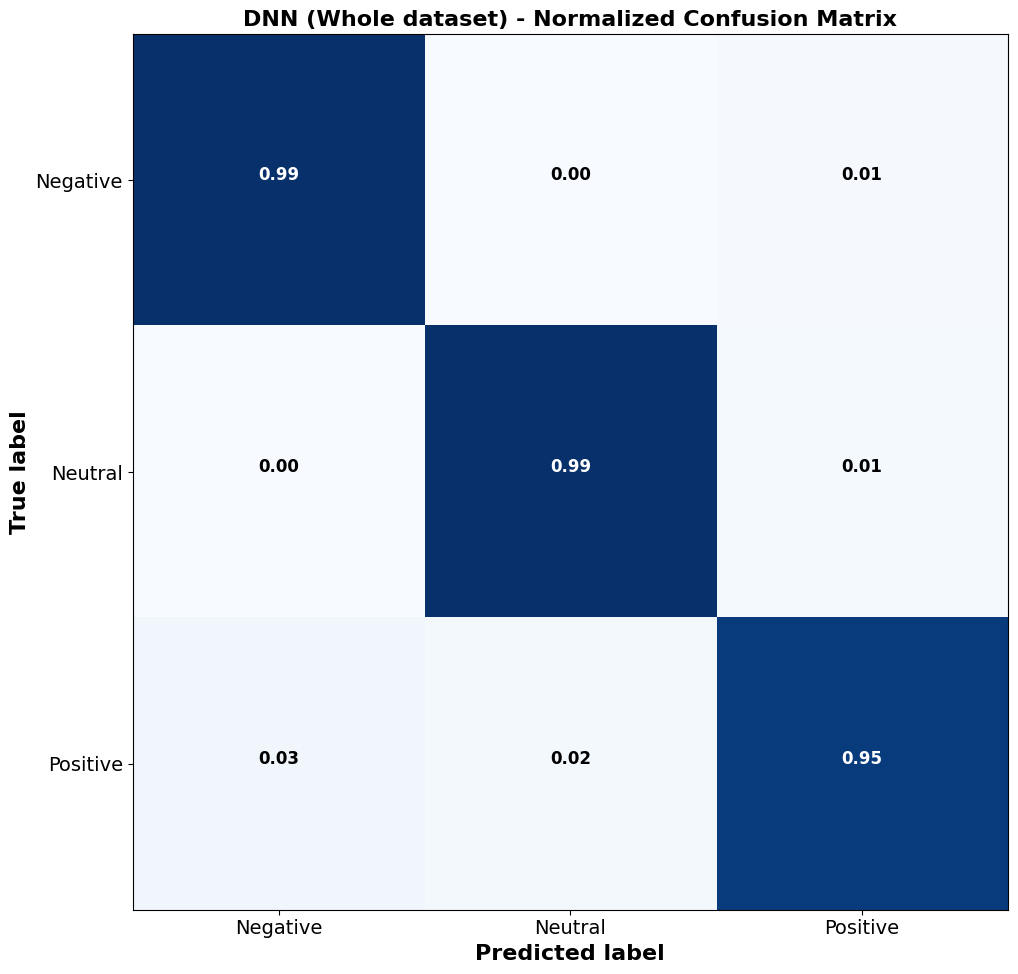

In [49]:
if all_dataset==True and only_fft==False:
  metrics_evolution(dnn_whole_h, model_type='DNN (Whole dataset)')
  model_performances(model='./best_dnn_whole_model.h5',x_test=x_test,y_test=y_test,model_type='DNN (Whole dataset)',normalized_CM=True)

#**4-Conclusions on the first stage**

*Some comments about modelization*
1. **Dataset: fft signals, Model: LSTM**: Using only fft signals results are good. Accuracy is about 92% with a good performance on predicting neutral and negative classes, less on positive.
2. **Dataset: fft signal, Model: GRU**: results in prediction of neutral and negative are too good to be true (100%), class positive still not well predicted. Possible overfitting phenomena (training stops before happens).
3. **Dataset: variables, Model: DNN**: huge improvements and good results in terms of classification performances. The model works well both from accuracy point of view and generalization capability point of view.
4. **Dateset: whole, Model: DNN**: Massive accuracy and overall performances. Model with most epochs used to train.



In conclusion, even if from a performance point of view using DNNs on variables or on the whole dataset, I'll proceed with using only the fft signal. This is due to the following reasons:
1. Stronger adherence on time series signals hypotesis
2. Usage of informations that can be easily processed and obtained.


#**5-Studing differences between group A and B**
The goal here is, once defined a new splitted dataset, finding possible differences between group A and group B in the dataset. In other words, are the model parameters different between these two groups even if the outcome is the same?

To find out if so, the following pipeline is followed:
1. Splitting the fft (sub)dataset in group A and B
2. Splitting A in train and validation sets. Training the model and avaluating the goodness of results. Possible changes in the model are allowed here.
3. Testing the model on B: if the results are good, probably the model trained on A will be the sae as the one trained on B, suggesting only less relevant differences between datasets.



## **5.1 Building subsets**


In [64]:
Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

In [65]:
# fft subset
fft_columns=X.columns[X.columns.str.contains('fft')]
X_fft=X[fft_columns]

# subset a and b
a_columns=X_fft.columns[X_fft.columns.str.contains('a')]
X_fft_a=X_fft[a_columns]

b_columns=X_fft.columns[X_fft.columns.str.contains('b')]
X_fft_b=X_fft[b_columns]

X_fft_a.head()


,fft_0_a,fft_1_a,fft_2_a,fft_3_a,fft_4_a,fft_5_a,fft_6_a,fft_7_a,fft_8_a,fft_9_a,...,fft_740_a,fft_741_a,fft_742_a,fft_743_a,fft_744_a,fft_745_a,fft_746_a,fft_747_a,fft_748_a,fft_749_a
0,-520.0,398.00,-201.0,-201.0,398.00,-52.2,121.00,-64.0,-64.0,121.00,...,179.0,26.4,-12.9,-12.9,26.4,-474.00,442.0,-222.00,-222.00,442.0
1,66.2,-4.30,43.6,43.6,-4.30,66.0,-29.00,73.3,73.3,-29.00,...,184.0,17.0,-18.9,-18.9,17.0,189.00,-19.6,-8.37,-8.37,-19.6
2,-90.8,204.00,-77.1,-77.1,204.00,-488.0,415.00,-187.0,-187.0,415.00,...,-796.0,631.0,-261.0,-261.0,631.0,-86.40,176.0,-100.00,-100.00,176.0
3,119.0,6.25,10.9,10.9,6.25,-333.0,283.00,-144.0,-144.0,283.00,...,-474.0,439.0,-221.0,-221.0,439.0,272.00,-87.7,32.40,32.40,-87.7
4,59.0,-2.37,10.8,10.8,-2.37,118.0,-1.81,26.7,26.7,-1.81,...,30.7,50.3,-111.0,-111.0,50.3,-2.43,30.5,-152.00,-152.00,30.5


In [66]:
# splitting train and validation
X_train, x_val, Y_train, y_val = train_test_split(X_fft_a, Y,random_state=111, test_size=0.2)

In [55]:
X_train.head()

,fft_0_a,fft_1_a,fft_2_a,fft_3_a,fft_4_a,fft_5_a,fft_6_a,fft_7_a,fft_8_a,fft_9_a,...,fft_740_a,fft_741_a,fft_742_a,fft_743_a,fft_744_a,fft_745_a,fft_746_a,fft_747_a,fft_748_a,fft_749_a
1404,-142.0,185.0,-79.60,-79.60,185.0,-43.3,96.0,-19.40,-19.40,96.0,...,93.9,32.70,-31.60,-31.60,32.70,-475.0,349.000,-237.0,-237.0,349.000
83,37.4,36.2,-26.80,-26.80,36.2,125.0,46.6,-66.40,-66.40,46.6,...,48.2,19.70,-33.10,-33.10,19.70,61.5,-0.897,-131.0,-131.0,-0.897
1318,144.0,11.4,4.06,4.06,11.4,-23.8,116.0,-107.00,-107.00,116.0,...,-165.0,185.00,-83.20,-83.20,185.00,-335.0,368.000,-164.0,-164.0,368.000
384,152.0,34.6,-34.30,-34.30,34.6,69.4,20.1,7.95,7.95,20.1,...,69.9,-11.80,6.24,6.24,-11.80,-16.5,-14.500,-18.5,-18.5,-14.500
1538,118.0,-12.3,-40.10,-40.10,-12.3,44.2,-34.6,19.40,19.40,-34.6,...,220.0,9.27,-41.30,-41.30,9.27,203.0,-9.700,-19.5,-19.5,-9.700


In [56]:
Y_train.head()

1404    0
83      2
1318    0
384     2
1538    1
Name: label, dtype: int64

In [69]:
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
x_test = np.array(X_fft_b).reshape((X_fft_b.shape[0], X_fft_b.shape[1],1))

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(Y)
y_val = pd.get_dummies(y_val)

## **5.2 - Model training on subset a**

In [70]:
def rnn_model(x_train,n_classes,n_recurrent_neurons,model_type='lstm'):
  input_layer = keras.layers.Input(shape=(x_train.shape[1], 1))

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(input_layer)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(input_layer)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  if model_type=='gru':
    x = keras.layers.GRU(n_recurrent_neurons, return_sequences=True)(x)
  elif model_type=='lstm':
    x = keras.layers.LSTM(n_recurrent_neurons, return_sequences=True)(x)

  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  x = keras.layers.Dropout(.5)(x)
  x = keras.layers.Flatten()(x)
  y = keras.layers.Dense(n_classes, activation='softmax')(x)

  return keras.models.Model(inputs=input_layer, outputs=y)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 750, 1)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 750, 256)          264192    
                                                                 
 lstm_4 (LSTM)               (None, 750, 256)          525312    
                                                                 
 lstm_5 (LSTM)               (None, 750, 256)          525312    
                                                                 
 dropout_41 (Dropout)        (None, 750, 256)          0         
                                                                 
 dense_49 (Dense)            (None, 750, 128)          32896     
                                                                 
 dropout_42 (Dropout)        (None, 750, 128)          0   

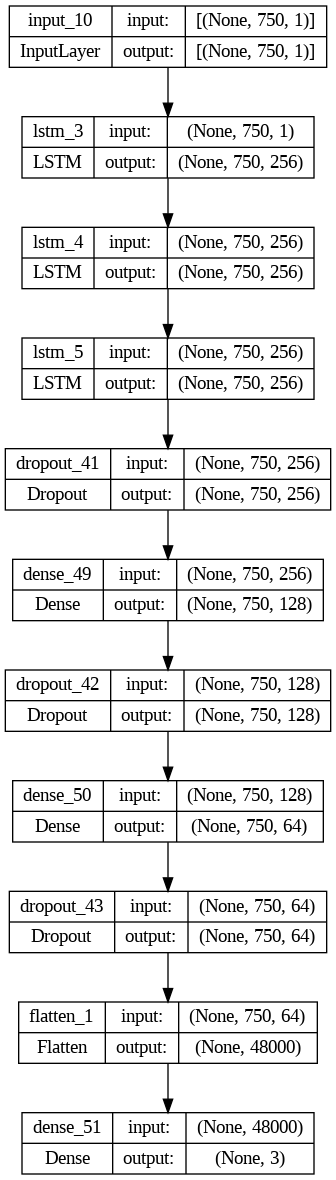

In [71]:
lstm_model_a = rnn_model(
    x_train=X_train,
    n_classes=3,
    n_recurrent_neurons=256,
    model_type='lstm'
)
print(lstm_model_a.summary())
keras.utils.plot_model(lstm_model_a, "lstm_subset_a.png", show_shapes=True)

In [72]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True,min_delta=0.01)
mc = ModelCheckpoint('./best_lstm_a_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

lstm_model_a.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

print('fft signal modeling throught LSTM')
lstm_a_h = lstm_model_a.fit(X_train, Y_train,
                  batch_size=32,
                  validation_data=(x_val, y_val),
                  epochs=50,
                  callbacks=[ es,mc, lr_schedule])

fft signal modeling throught LSTM
Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7994
Epoch 1: val_accuracy improved from -inf to 0.89930, saving model to ./best_lstm_a_model.h5
54/54 [==============================] - 19s 159ms/step - loss: 0.5404 - accuracy: 0.7994 - val_loss: 0.2306 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.9226
Epoch 2: val_accuracy did not improve from 0.89930
54/54 [==============================] - 8s 140ms/step - loss: 0.2255 - accuracy: 0.9226 - val_loss: 0.2421 - val_accuracy: 0.8876 - lr: 9.0484e-04
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.2395 - accuracy: 0.9126
Epoch 3: val_accuracy did not improve from 0.89930
54/54 [==============================] - 7s 135ms/step - loss: 0.2395 - accuracy: 0.9126 - val_loss: 0.3927 - val_accuracy: 0.8618 - lr: 8.1873e-04
Epoch 4/50
54/54 [==============================]

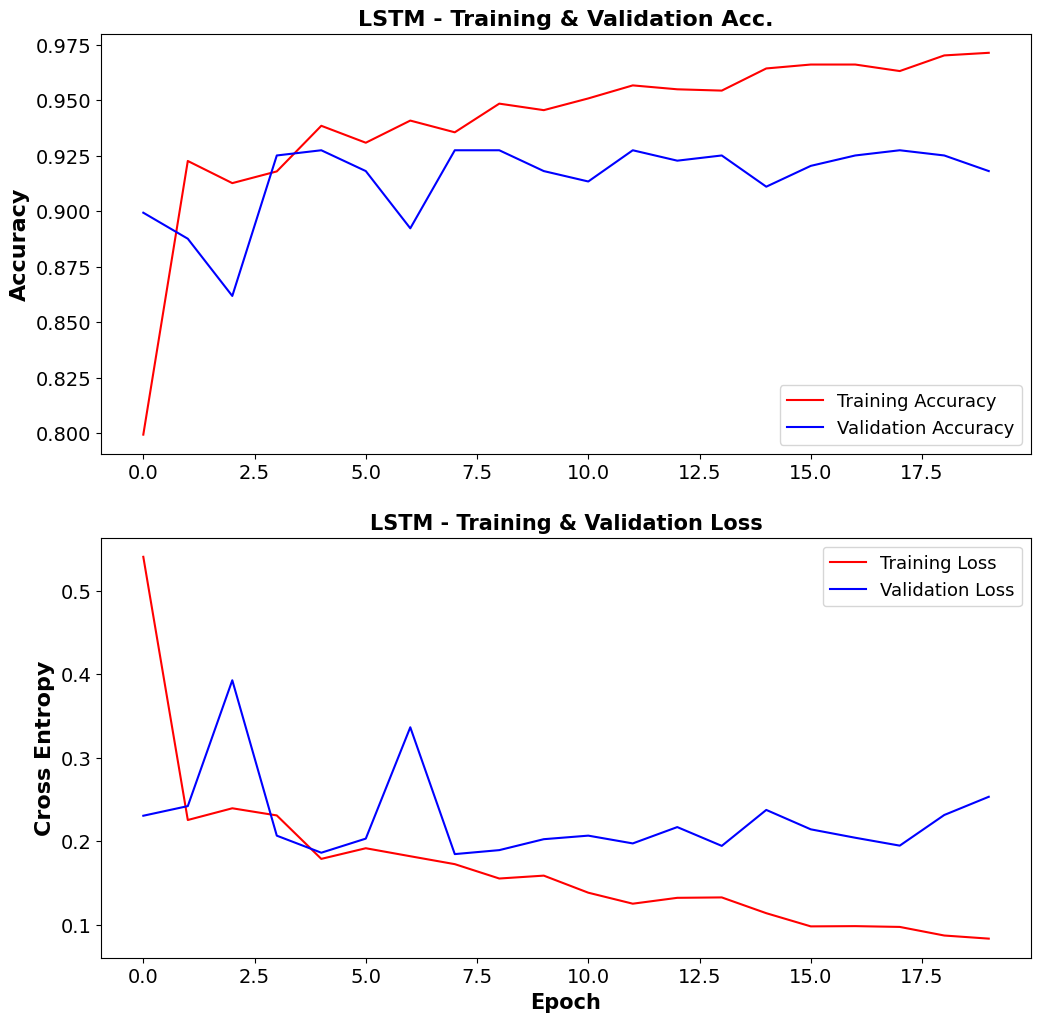

------------------------------------------------------------------
Model performances of model LSTM saved as ./best_lstm_a_model.h5:

Test Acc.: 94.090%

67/67 [==============================] - 5s 54ms/step
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       708
           1       1.00      1.00      1.00       716
           2       0.98      0.84      0.90       708

    accuracy                           0.94      2132
   macro avg       0.95      0.94      0.94      2132
weighted avg       0.95      0.94      0.94      2132

Normalized confusion matrix


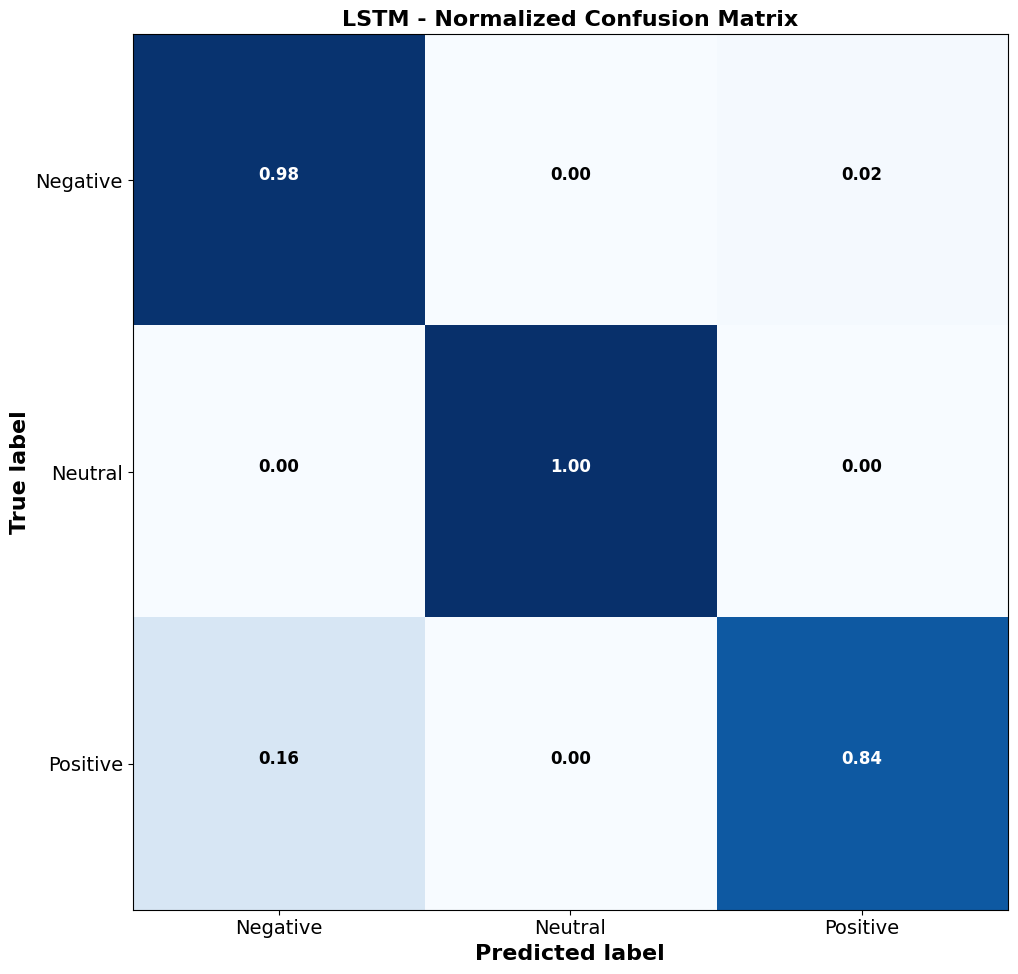

In [74]:

metrics_evolution(lstm_a_h, model_type='LSTM')
model_performances(model='./best_lstm_a_model.h5',x_test=x_test,y_test=y_test,model_type='LSTM',normalized_CM=True)

# **4- Conclusion**
